<a href="https://colab.research.google.com/github/sayan112207/Stable-Diffusion/blob/main/Fine_Tuning_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.2 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Sun Feb 16 17:35:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
import torch
from datasets import load_dataset
from diffusers import StableDiffusionXLPipeline
from peft import LoraConfig, get_peft_model
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
class ImpressionismDataset(Dataset):
    def __init__(self, dataset, tokenizer, resolution=512):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.resolution = resolution
        self.transform = transforms.Compose([
            transforms.Resize((resolution, resolution)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert("RGB")
        image = self.transform(image)

        # Create prompt combining original artwork info with pencil sketch style
        artist = item.get("artist", "unknown artist")
        title = item.get("title", "artwork")
        prompt = f"pencil sketch of impressionist painting '{title}' by {artist}, detailed pencil drawing, graphite art, intricate shading"

        encoded = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )

        return {
            "pixel_values": image,
            "input_ids": encoded.input_ids[0]
        }

In [ ]:
def load_impressionism_dataset():
    """
    Load only Impressionism style paintings from WikiArt
    """
    # Load WikiArt dataset
    dataset = load_dataset("huggan/wikiart", split="train")

    # Filter for Impressionism style (style ID 12)
    impressionism_dataset = dataset.filter(lambda x: x["style"] == 12)

    # Take first 100 images for faster training
    return impressionism_dataset.select(range(min(len(impressionism_dataset), 100)))

In [ ]:
def create_sketch_lora_config():
    return LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=[
            "to_k",
            "to_q",
            "to_v",
            "to_out.0"
        ],
        lora_dropout=0.1,
        bias="none",
    )

def train_sketch_lora(
    pretrained_model_name="stabilityai/sd-turbo",
    output_dir="impressionism_sketch_lora_output",
    num_epochs=30,
    learning_rate=1e-4,
    batch_size=1,
    early_stopping_patience=2  # Number of epochs to wait before early stopping if no improvement
):
    # Initialize models
    pipeline = StableDiffusionXLPipeline.from_pretrained(
        pretrained_model_name,
        torch_dtype=torch.float16,
        variant="fp16"
    )

    tokenizer = pipeline.tokenizer
    text_encoder = pipeline.text_encoder
    vae = pipeline.vae
    unet = pipeline.unet

    # Setup LoRA
    lora_config = create_sketch_lora_config()
    unet = get_peft_model(unet, lora_config)

    # Freeze non-LoRA parameters
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)

    # Load Impressionism dataset
    dataset = load_impressionism_dataset()
    train_dataset = ImpressionismDataset(dataset, tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Optimizer
    optimizer = torch.optim.AdamW(
        unet.parameters(),
        lr=learning_rate,
        betas=(0.9, 0.999),
        weight_decay=0.01
    )

    # Training loop setup
    device = "cuda" if torch.cuda.is_available() else "cpu"
    unet.to(device)
    vae.to(device)
    text_encoder.to(device)

    print(f"Starting training with {len(dataset)} Impressionism paintings")

    # For tracking loss and early stopping
    epoch_losses = []
    epochs_no_improve = 0
    best_loss = float('inf')

    for epoch in range(num_epochs):
        unet.train()
        total_loss = 0
        num_batches = len(train_dataloader)

        # Create a tqdm progress bar for the epoch
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for batch in progress_bar:
            pixel_values = batch["pixel_values"].to(device, dtype=torch.float16)
            input_ids = batch["input_ids"].to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                latents = vae.encode(pixel_values).latent_dist.sample()
                latents = latents * 0.18215
                encoder_hidden_states = text_encoder(input_ids)[0]

            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, pipeline.scheduler.config.num_train_timesteps, (latents.shape[0],), device=device)
            noisy_latents = pipeline.scheduler.add_noise(latents, noise, timesteps)

            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
            loss = F.mse_loss(noise_pred, noise, reduction="mean")

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / num_batches
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Average loss = {avg_loss:.6f}")

        # Early stopping: if the loss does not improve, increment counter
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered. No improvement for {early_stopping_patience} consecutive epochs.")
            break

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            save_path = os.path.join(output_dir, f"checkpoint-{epoch+1}")
            os.makedirs(save_path, exist_ok=True)
            unet.save_pretrained(save_path)

    # Plot loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.grid(True)
    plt.show()

    return unet  # Optionally return the final model for further use

In [ ]:
from diffusers import StableDiffusionXLPipeline
from transformers import AutoTokenizer # Import AutoTokenizer
import torch

def load_pipeline_with_tokenizer(model_name="stabilityai/sd-turbo"):
    """
    Loads the sd-turbo pipeline. If its tokenizer is None,
    then load a fallback tokenizer from a compatible SDXL model.
    """
    pipeline = StableDiffusionXLPipeline.from_pretrained(
        model_name,
        torch_dtype=torch.float16
    ).to("cuda")

    if pipeline.tokenizer is None:
        print("Pipeline tokenizer is missing. Loading fallback tokenizer from stable-diffusion-xl-base-1.0.")
        pipeline.tokenizer = AutoTokenizer.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0")

    return pipeline

In [ ]:
import torch
from diffusers import StableDiffusionXLPipeline
from transformers import AutoTokenizer, CLIPTokenizer, CLIPTextModel

def test_model_from_trained_unet(trained_unet, user_query):
    """
    Test the model using the trained UNet with a user input prompt.
    """

    # Add validation check
    if trained_unet is None:
        raise ValueError("trained_unet is None. Please ensure the model is properly loaded.")

    # Print model info for debugging
    print(f"UNet type: {type(trained_unet)}")

    # First load tokenizers
    tokenizer_1 = CLIPTokenizer.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        subfolder="tokenizer"
    )
    tokenizer_2 = CLIPTokenizer.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        subfolder="tokenizer_2"
    )

    # Load text encoders
    text_encoder_1 = CLIPTextModel.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        subfolder="text_encoder",
        torch_dtype=torch.float16
    )
    text_encoder_2 = CLIPTextModel.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        subfolder="text_encoder_2",
        torch_dtype=torch.float16
    )

    # Load the pipeline with all components
    pipeline = StableDiffusionXLPipeline.from_pretrained(
        "stabilityai/sd-turbo",
        text_encoder=text_encoder_1,
        text_encoder_2=text_encoder_2,
        tokenizer=tokenizer_1,
        tokenizer_2=tokenizer_2,
        torch_dtype=torch.float16,
        use_safetensors=True
    ).to("cuda")

    # Handle LoRA weights
    if hasattr(trained_unet, "merge_and_unload"):
        pipeline.unet = trained_unet.merge_and_unload()
    else:
        pipeline.unet = trained_unet

    # Print debug info
    print("Pipeline components status:")
    print(f"Tokenizer 1: {pipeline.tokenizer is not None}")
    print(f"Tokenizer 2: {pipeline.tokenizer_2 is not None}")
    print(f"Text Encoder 1: {pipeline.text_encoder is not None}")
    print(f"Text Encoder 2: {pipeline.text_encoder_2 is not None}")
    print(f"UNet: {pipeline.unet is not None}")

    # Generate image
    full_prompt = f"{user_query}, impressionist style converted to pencil drawing, detailed graphite art, intricate shading"

    output = pipeline(
        prompt=full_prompt,
        negative_prompt="low quality, bad anatomy, worst quality, low resolution",
        num_images_per_prompt=1,
        guidance_scale=3.0,
        num_inference_steps=20,
        height=512,
        width=512
    )

    return output.images[0]

In [ ]:
import torch
from diffusers import StableDiffusionXLPipeline, AutoencoderKL
from transformers import CLIPTokenizer, CLIPTextModel

def test_model(trained_unet, user_query):
    """
    Test the model using the trained UNet with a user input prompt.
    """
    print(f"UNet type: {type(trained_unet)}")

    # Explicitly load base components
    base_model_path = "stabilityai/stable-diffusion-xl-base-1.0"

    # Load tokenizer explicitly
    tokenizer = CLIPTokenizer.from_pretrained(
        base_model_path,
        subfolder="tokenizer",
        use_fast=False
    )

    # Load text encoder
    text_encoder = CLIPTextModel.from_pretrained(
        base_model_path,
        subfolder="text_encoder",
        torch_dtype=torch.float16
    )

    # Load VAE
    vae = AutoencoderKL.from_pretrained(
        "madebyollin/sdxl-vae-fp16-fix",
        torch_dtype=torch.float16
    )

    # Initialize pipeline with explicit components
    pipeline = StableDiffusionXLPipeline.from_pretrained(
        "stabilityai/sd-turbo",
        tokenizer=tokenizer,
        text_encoder=text_encoder,
        vae=vae,
        torch_dtype=torch.float16,
        variant="fp16",
    ).to("cuda")

    # Set UNet
    if hasattr(trained_unet, "merge_and_unload"):
        print("Merging PEFT layers...")
        pipeline.unet = trained_unet.merge_and_unload()
    else:
        pipeline.unet = trained_unet

    pipeline.unet.eval()

    print("\nPipeline components status:")
    print(f"Tokenizer: {pipeline.tokenizer is not None}")
    print(f"Text Encoder: {pipeline.text_encoder is not None}")
    print(f"UNet: {pipeline.unet is not None}")
    print(f"VAE: {pipeline.vae is not None}")

    # Generate image
    full_prompt = f"{user_query}, impressionist style converted to pencil drawing, detailed graphite art, intricate shading"

    try:
        with torch.inference_mode():
            output = pipeline(
                prompt=full_prompt,
                negative_prompt="low quality, bad anatomy, worst quality, low resolution",
                num_images_per_prompt=1,
                guidance_scale=3.0,
                num_inference_steps=20,
                height=1024,
                width=1024
            )
        return output.images[0]

    except Exception as e:
        print(f"\nDetailed error information:")
        print(f"Error type: {type(e)}")
        print(f"Error message: {str(e)}")
        print(f"Pipeline device: {pipeline.device}")
        print(f"UNet device: {pipeline.unet.device}")
        print(f"Tokenizer type: {type(pipeline.tokenizer)}")
        torch.cuda.empty_cache()
        raise

model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

dataset_infos.json:   0%|          | 0.00/5.91k [00:00<?, ?B/s]

train-00000-of-00072.parquet:   0%|          | 0.00/522M [00:00<?, ?B/s]

train-00001-of-00072.parquet:   0%|          | 0.00/518M [00:00<?, ?B/s]

train-00002-of-00072.parquet:   0%|          | 0.00/533M [00:00<?, ?B/s]

train-00003-of-00072.parquet:   0%|          | 0.00/533M [00:00<?, ?B/s]

train-00004-of-00072.parquet:   0%|          | 0.00/532M [00:00<?, ?B/s]

train-00005-of-00072.parquet:   0%|          | 0.00/519M [00:00<?, ?B/s]

train-00006-of-00072.parquet:   0%|          | 0.00/523M [00:00<?, ?B/s]

train-00007-of-00072.parquet:   0%|          | 0.00/532M [00:00<?, ?B/s]

train-00008-of-00072.parquet:   0%|          | 0.00/532M [00:00<?, ?B/s]

train-00009-of-00072.parquet:   0%|          | 0.00/531M [00:00<?, ?B/s]

train-00010-of-00072.parquet:   0%|          | 0.00/530M [00:00<?, ?B/s]

train-00011-of-00072.parquet:   0%|          | 0.00/539M [00:00<?, ?B/s]

train-00012-of-00072.parquet:   0%|          | 0.00/523M [00:00<?, ?B/s]

train-00013-of-00072.parquet:   0%|          | 0.00/555M [00:00<?, ?B/s]

train-00014-of-00072.parquet:   0%|          | 0.00/453M [00:00<?, ?B/s]

train-00015-of-00072.parquet:   0%|          | 0.00/563M [00:00<?, ?B/s]

train-00016-of-00072.parquet:   0%|          | 0.00/510M [00:00<?, ?B/s]

train-00017-of-00072.parquet:   0%|          | 0.00/459M [00:00<?, ?B/s]

train-00018-of-00072.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

train-00019-of-00072.parquet:   0%|          | 0.00/453M [00:00<?, ?B/s]

train-00020-of-00072.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

train-00021-of-00072.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

train-00022-of-00072.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

train-00023-of-00072.parquet:   0%|          | 0.00/453M [00:00<?, ?B/s]

train-00024-of-00072.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

train-00025-of-00072.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

train-00026-of-00072.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00027-of-00072.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

train-00028-of-00072.parquet:   0%|          | 0.00/442M [00:00<?, ?B/s]

train-00029-of-00072.parquet:   0%|          | 0.00/449M [00:00<?, ?B/s]

train-00030-of-00072.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00031-of-00072.parquet:   0%|          | 0.00/450M [00:00<?, ?B/s]

train-00032-of-00072.parquet:   0%|          | 0.00/460M [00:00<?, ?B/s]

train-00033-of-00072.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

train-00034-of-00072.parquet:   0%|          | 0.00/466M [00:00<?, ?B/s]

train-00035-of-00072.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

train-00036-of-00072.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00037-of-00072.parquet:   0%|          | 0.00/453M [00:00<?, ?B/s]

train-00038-of-00072.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

train-00039-of-00072.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

train-00040-of-00072.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

train-00041-of-00072.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

train-00042-of-00072.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00043-of-00072.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

train-00044-of-00072.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

train-00045-of-00072.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00046-of-00072.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

train-00047-of-00072.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

train-00048-of-00072.parquet:   0%|          | 0.00/491M [00:00<?, ?B/s]

train-00049-of-00072.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

train-00050-of-00072.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

train-00051-of-00072.parquet:   0%|          | 0.00/515M [00:00<?, ?B/s]

train-00052-of-00072.parquet:   0%|          | 0.00/514M [00:00<?, ?B/s]

train-00053-of-00072.parquet:   0%|          | 0.00/509M [00:00<?, ?B/s]

train-00054-of-00072.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

train-00055-of-00072.parquet:   0%|          | 0.00/453M [00:00<?, ?B/s]

train-00056-of-00072.parquet:   0%|          | 0.00/414M [00:00<?, ?B/s]

train-00057-of-00072.parquet:   0%|          | 0.00/405M [00:00<?, ?B/s]

train-00058-of-00072.parquet:   0%|          | 0.00/359M [00:00<?, ?B/s]

train-00059-of-00072.parquet:   0%|          | 0.00/304M [00:00<?, ?B/s]

train-00060-of-00072.parquet:   0%|          | 0.00/449M [00:00<?, ?B/s]

train-00061-of-00072.parquet:   0%|          | 0.00/438M [00:00<?, ?B/s]

train-00062-of-00072.parquet:   0%|          | 0.00/447M [00:00<?, ?B/s]

train-00063-of-00072.parquet:   0%|          | 0.00/435M [00:00<?, ?B/s]

train-00064-of-00072.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00065-of-00072.parquet:   0%|          | 0.00/439M [00:00<?, ?B/s]

train-00066-of-00072.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

train-00067-of-00072.parquet:   0%|          | 0.00/436M [00:00<?, ?B/s]

train-00068-of-00072.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

train-00069-of-00072.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

train-00070-of-00072.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

train-00071-of-00072.parquet:   0%|          | 0.00/367M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/81444 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/45 [00:00<?, ?it/s]

Filter:   0%|          | 0/81444 [00:00<?, ? examples/s]

Starting training with 100 Impressionism paintings


Epoch 1/30:   0%|          | 0/100 [00:00<?, ?batch/s]

Epoch 1: Average loss = 0.281024


Epoch 2/30:   0%|          | 0/100 [00:00<?, ?batch/s]

Epoch 2: Average loss = 0.246042


Epoch 3/30:   0%|          | 0/100 [00:00<?, ?batch/s]

Epoch 3: Average loss = 0.188476


Epoch 4/30:   0%|          | 0/100 [00:00<?, ?batch/s]

Epoch 4: Average loss = 0.193370


Epoch 5/30:   0%|          | 0/100 [00:00<?, ?batch/s]

Epoch 5: Average loss = 0.234546
Early stopping triggered. No improvement for 2 consecutive epochs.


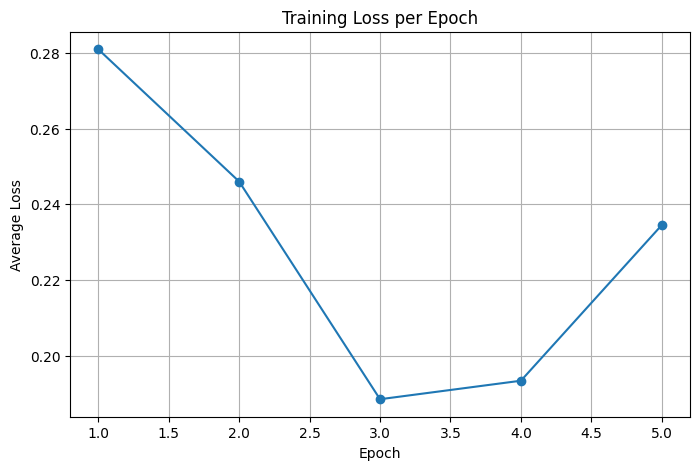

In [ ]:
trained_unet = train_sketch_lora()

In [ ]:
print(trained_unet)

PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Linear(in_features=320, out_features=320, bias=True)
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    (to_q): lora.Linear(
                      (base_layer): Linear(in_fea

In [ ]:
# If your 'trained_unet' is a PEFT model or a Hugging Face model with save_pretrained():
save_path = "my_trained_unet"
trained_unet.save_pretrained(save_path)

print(f"Model saved to {save_path}")

Model saved to my_trained_unet
